Similarly, this notebook was to make scatter plot of S and T.

1) Compare with obs.

2) Compare with nowcasts.

In [1]:
import os
import glob

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

import sys
sys.path.append('/ocean/jieliu/research/meopar/analysis/Nancy/strat/comparisons/')
import comparisons

from salishsea_tools import tidetools, viz_tools
from salishsea_tools.nowcast import analyze

import seaborn as sns

import ACTDR
import pandas as pd
%matplotlib inline

In [2]:
sns.set_color_codes()

In [3]:
paths = {'nowcast': '/results/SalishSea/nowcast/',
         'RFdaily': '/data/jieliu/MEOPAR/IOS/octRFdaily/',
         '1e-05': '/data/jieliu/MEOPAR/IOS/oct1e05/',
          '1e-051e-06':'/data/jieliu/MEOPAR/IOS/oct1e061e05/'}
grid_B = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')    
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/mesh_mask.nc')
FIRST_NOWCAST = datetime.datetime(2014, 10,27)

In [4]:
def get_model_cast(year, month, day, data,lon,lat, field,model_path, cast):
    """Get the model daily mean, max and min corresponding to given year, month, day and lat/lon"""
    
    if field =='Salinity':
        var = 'vosaline'
    elif field == 'Temperature':
        var = 'votemper'
        
    date = datetime.datetime(year, month, day)
    data_m = data[data['Month'] == month]
    num_casts = len(data_m.index)
    #Look up grid point (nowcasts)
    bathy, X, Y= tidetools.get_bathy_data(grid_B)
    j, i = tidetools.find_closest_model_point(lon, lat, X, Y, bathy)
    ## look up new results
    filename_pattern = '1h_Plume{i}_T.nc'
    if num_casts ==13:
        path = os.path.join(model_path, filename_pattern.format( i = cast+1))
    elif num_casts ==26:
        path = os.path.join(model_path, filename_pattern.format( i = cast+14)) 
    ## for new result
    depths = mesh.variables['gdept'][0,:,j,i]
    new_file = nc.Dataset(path);
    var_model = new_file.variables[var][:,:,0,0]
    var_model, tmask = mask_model(j,i, var_model)
     # Daily mean/min/max
    min_daily = np.min(var_model[(day-1)*24:day*24,:], axis=0)
    max_daily = np.max(var_model[(day-1)*24:day*24,:], axis=0)
    mean_daily = np.mean(var_model[(day-1)*24:day*24,:], axis=0)

    return mean_daily, max_daily, min_daily, depths, tmask

In [5]:
def mask_model(j,i,var_model):
    """Mask a model variable at a grid point"""
    
    tmask = np.abs(1-mesh.variables['tmask'][:, :, j, i])
    tmask = tmask + np.zeros(var_model.shape)
    var_masked = np.ma.array(var_model, mask=tmask)
    return var_masked, tmask[0,:]

In [6]:
def prepare_cast_comparison(dep_obs, var_obs, year, month, day, lon, lat, cast,data,field,model_path):
    """Gather model and observed cast data for comparison"""
    
    # model data 
    mean_mod, max_mod, min_mod, dep_mod, tmask = get_model_cast(year, month, day, data,lon, lat,\
                                                        field, model_path,cast)
    
    # interp observations
    interp_obs = comparisons.interpolate_depth(var_obs, dep_obs, dep_mod)
    interp_obs = np.ma.array(interp_obs, mask=tmask)
    
    return interp_obs, mean_mod, max_mod, min_mod, dep_mod

In [7]:
ACTDR.load_dat('SOG_2000.dat')

('> open ', 'SOG_2000.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', 'SOG_2000.dat')
> complete


In [8]:
data = pd.DataFrame(ACTDR.CTD_DAT)
data_fall = data[(data.Year>=2014) & (data.Month >=10)]

In [9]:
sns.set_context('talk')

In [30]:
def scatter_compare(data, month,field, cmin, cmax, model_path,ax, units):
    sal_flags=[]
    cast = 0
    for dep_obs, var_obs, lon, lat, year, day in zip(data['Depth'],
                                                        data[field],
                                                        data['Longitude'],
                                                        data['Latitude'],
                                                        data['Year'],
                                                        data['Day']):

        interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                            year, month, day,lon, lat, cast,data,field,model_path)
        thres=1; date=datetime.datetime(year, month, day)
        if field == 'Salinity':
            flag, k=classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres)
            if flag == 0:
                print('Salinity within {} at depth {}, {}, {}, {}'.format(thres, dep_mod[k], lon, lat, date))
            if flag == 1:
                print('Too salty at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            if flag == -1:
                print('Too fresh at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            sal_flags.append(flag)
        ax.errorbar(interp_obs, mean_mod, yerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='o',marker='', 
                     zorder=0, ecolor='gray',lw=1)
        sc = ax.scatter(interp_obs, mean_mod, marker='o', edgecolor='',c= dep_mod, 
                         norm=mcolors.LogNorm(), cmap='Spectral', vmin=0.5, vmax=300, s=50)
        ax.set_xlim([cmin, cmax])
        ax.set_ylim([cmin, cmax])
        ax.plot([cmin, cmax],[cmin, cmax], 'r-',zorder=0)
        cast = cast+1
    cb = plt.colorbar(sc, ax=ax)
    ticks = [1, 10, 25, 50, 100, 200, 400]
    cb.set_ticks(ticks)
    cb.set_ticklabels(ticks)
    cb.set_label('Depth [m]')
    ax.set_xlabel('Observed {} [{}]'.format(field, units))
    ax.set_ylabel('Modelled {} [{}]'.format(field, units))
    return sal_flags

In [31]:
def compare_region(data, lon_min, lon_max, lat_min, lat_max,model_path, title, smin=18, smax=32, tmin=8, tmax=16):
    cmap = sns.diverging_palette(220, 20,as_cmap=True)
    data_region  = comparisons.isolate_region(data,lon_min, lon_max, lat_min, lat_max)
    #sal
    fig2,ax2 = plt.subplots(1,1)
    field = 'Salinity'; 
    sal_flags=scatter_compare(data_region, month,field, smin,smax,model_path,ax2,'psu')
    ax2.set_title('{} - {}'.format(title, field))
    #temp
    fig3,ax3 = plt.subplots(1,1)
    field = 'Temperature';
    scatter_compare(data_region, month,field, tmin,tmax,model_path,ax3,'deg C')
    ax3.set_title('{} - {}'.format(title, field))
    #map
    fig1, ax1 = plt.subplots(1,1)
    ax1.scatter(data_region['Longitude'], data_region['Latitude'], s=50,c=sal_flags, cmap=cmap,vmin=-1,vmax=1)
    viz_tools.plot_coastline(ax1,grid_B, coords='map')
    ax1.set_xlim([lon_min, lon_max])
    ax1.set_ylim([lat_min, lat_max])
    ax1.set_title(title)
    return fig1, ax1

In [32]:
def classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres):

    interp_obs = np.ma.masked_invalid(interp_obs)
    nonmasked = np.ma.flatnotmasked_edges(interp_obs)
    k=nonmasked[0]
    if (min_mod[k] -interp_obs[k] >thres) :
        flag = 1 #salty surface
    elif (max_mod[k] - interp_obs[k] )<-thres:
        flag = -1 #fresh surface
    else:
        flag =0  #ok
    
    return flag, k

# Southern Sog

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.429833333, 49.2795, 2014-10-02 00:00:00
Salinity within 1 at depth 5.50015068054, -123.7185, 49.2735, 2014-10-02 00:00:00
Salinity within 1 at depth 3.50003051758, -123.082333333, 48.8425, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too fresh at depth 1.50000309944, -123.568166667, 49.201, 2014-10-02 00:00:00
Too fresh at depth 2.50001144409, -123.303833333, 48.9031666667, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.027, 48.772, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.180333333, 48.8565, 2014-10-28 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Too salty at de

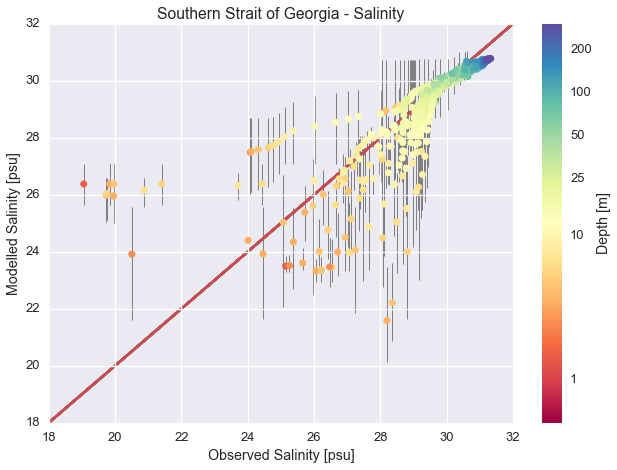

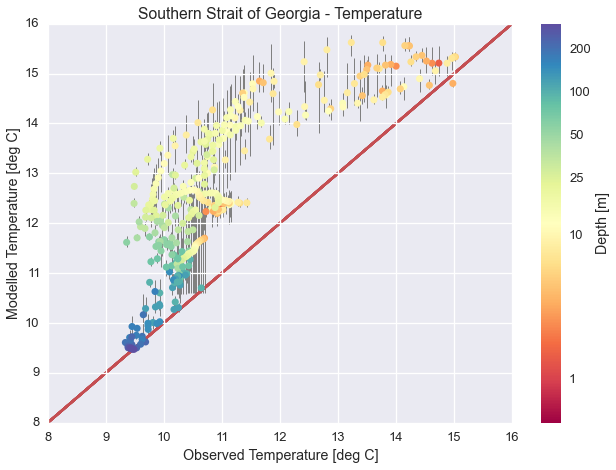

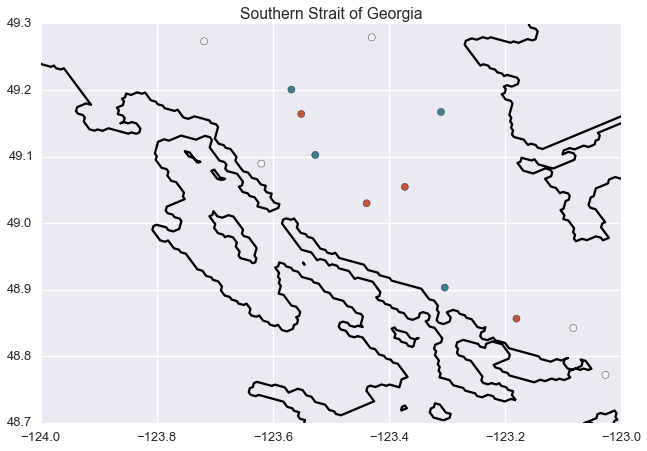

In [33]:
lon_min=-124
lon_max=-123
lat_min=48.7
lat_max=49.3
fig1,ax1 = compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, paths['RFdaily'],'Southern Strait of Georgia')
ax1.plot(49.2611, -123.2531, 'r*')

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.429833333, 49.2795, 2014-10-02 00:00:00
Salinity within 1 at depth 5.50015068054, -123.7185, 49.2735, 2014-10-02 00:00:00
Salinity within 1 at depth 3.50003051758, -123.082333333, 48.8425, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too fresh at depth 1.50000309944, -123.568166667, 49.201, 2014-10-02 00:00:00
Too fresh at depth 2.50001144409, -123.303833333, 48.9031666667, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.027, 48.772, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.180333333, 48.8565, 2014-10-28 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Salinity within 1 at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Too sal

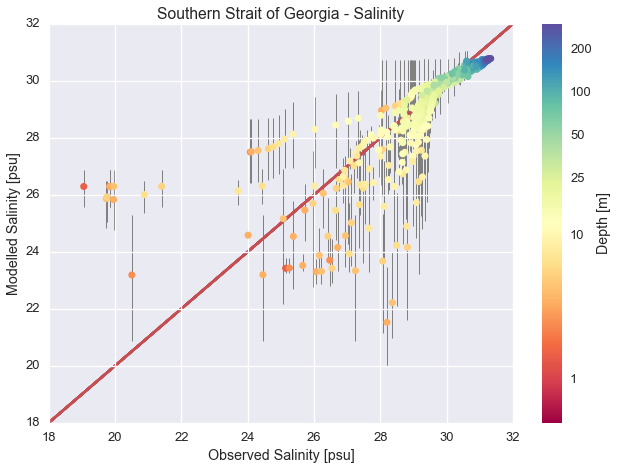

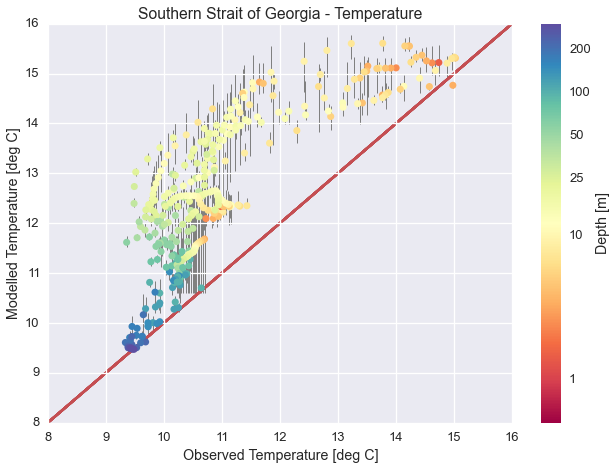

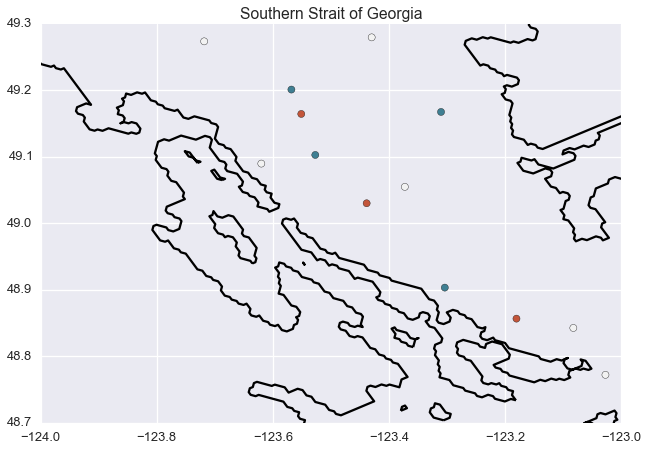

In [34]:
lon_min=-124
lon_max=-123
lat_min=48.7
lat_max=49.3
fig1,ax1 = compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, paths['1e-05'],'Southern Strait of Georgia')
ax1.plot(49.2611, -123.2531, 'r*')

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.429833333, 49.2795, 2014-10-02 00:00:00
Salinity within 1 at depth 5.50015068054, -123.7185, 49.2735, 2014-10-02 00:00:00
Salinity within 1 at depth 3.50003051758, -123.082333333, 48.8425, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too fresh at depth 1.50000309944, -123.568166667, 49.201, 2014-10-02 00:00:00
Too fresh at depth 2.50001144409, -123.303833333, 48.9031666667, 2014-10-03 00:00:00
Salinity within 1 at depth 3.50003051758, -123.027, 48.772, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.180333333, 48.8565, 2014-10-28 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Too salty at de

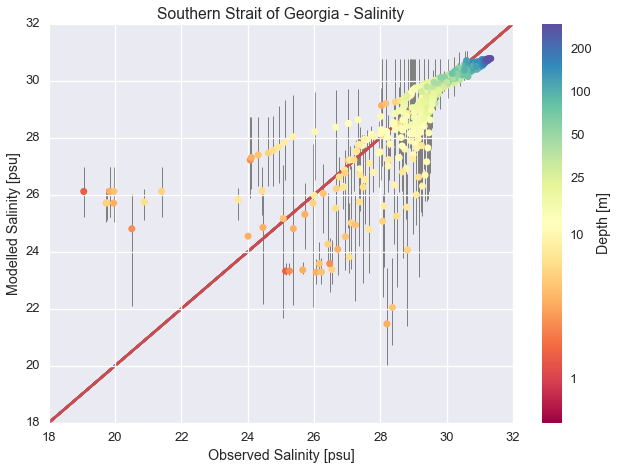

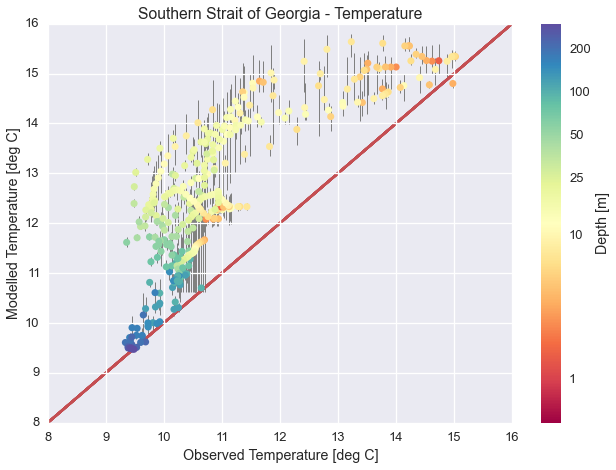

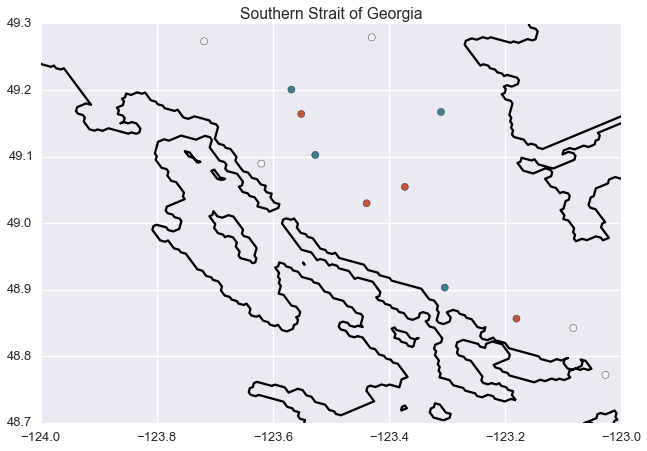

In [35]:
lon_min=-124
lon_max=-123
lat_min=48.7
lat_max=49.3
fig1,ax1 = compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, paths['1e-051e-06'],'Southern Strait of Georgia')
ax1.plot(49.2611, -123.2531, 'r*')

# Northern sog

In [38]:
data_region  = comparisons.isolate_region(data_fall,lon_min, lon_max, lat_min, lat_max)
data_m = data[data['Month'] == month]
num_casts = len(data_m.index)
num_casts

26

Salinity within 1 at depth 5.50015068054, -123.368666667, 49.422, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -124.739833333, 49.7013333333, 2014-10-04 00:00:00
Salinity within 1 at depth 3.50003051758, -124.675, 49.6345, 2014-10-04 00:00:00
Salinity within 1 at depth 3.50003051758, -124.472333333, 49.5313333333, 2014-10-05 00:00:00
Salinity within 1 at depth 3.50003051758, -124.545666667, 49.4931666667, 2014-10-05 00:00:00
Salinity within 1 at depth 3.50003051758, -124.446166667, 49.381, 2014-10-05 00:00:00
Salinity within 1 at depth 4.5000705719, -124.237666667, 49.3316666667, 2014-10-05 00:00:00
Salinity within 1 at depth 3.50003051758, -124.143333333, 49.3916666667, 2014-10-06 00:00:00
Too fresh at depth 3.50003051758, -123.238666667, 49.6, 2014-10-07 00:00:00
Salinity within 1 at depth 4.5000705719, -123.622833333, 49.3938333333, 2014-10-07 00:00:00
Too fresh at depth 3.50003051758, -124.021666667, 49.799, 2014-10-08 00:00:00
Salinity within 1 at depth 4.5000705719, -124

RuntimeError: No such file or directory

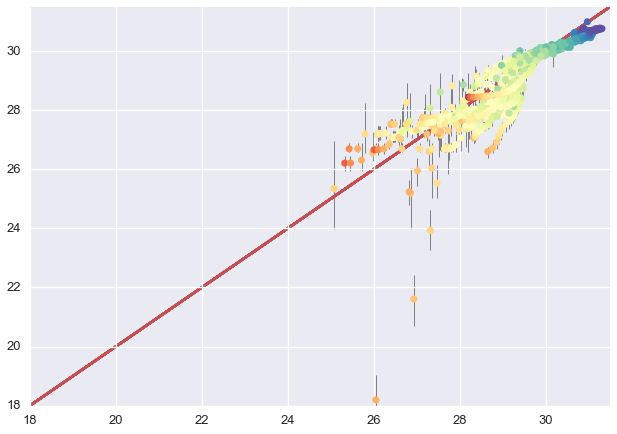

In [39]:
lon_min=-125.1
lon_max=-123
lat_min=49.3
lat_max=50
compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, paths['RFdaily'],'Northern Strait of Georgia',\
              smin=18,smax=31.5, tmin=7, tmax=16)